In [68]:
import pandas as pd
import os
import zipfile
import StringIO
import requests
import statsmodels.api as sm
import patsy
import numpy as np
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')
%matplotlib inline

In [2]:
# Only set this to true if you want to redownload all the 10s of gigabytes of raw data
REDOWNLOAD_RAW = False
if REDOWNLOAD_RAW:
    raw_input("Are you sure you want to redownload everything?")

In [3]:
SAVE_FIGS = True

In [37]:
COLORS = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

# Death data

In [4]:
BASE_URL = "https://www.nber.org/mortality/{0}/mort{0}.csv.zip"
DOWNLOAD_DEST_BASE = 'nchs_mcd_rawdata'
START_YEAR = 1979
END_YEAR = 2017

In [5]:
# If raw data folder doesn't exist, create it
if not os.path.exists(DOWNLOAD_DEST_BASE):
    print 'Making "{0}" directory...'.format(DOWNLOAD_DEST_BASE)
    os.makedirs('{0}'.format(DOWNLOAD_DEST_BASE))

In [6]:
def download_raw_data_by_year(year, base_url=BASE_URL, download_dest_base=DOWNLOAD_DEST_BASE):
    """
    See documentation stuff here:
    https://www.nber.org/data/vital-statistics-mortality-data-multiple-cause-of-death.html
    """
    year = str(year)
    
    # Check if already exists
    if os.path.exists(os.path.join(download_dest_base, '{0}.csv'.format(year))):
        if not REDOWNLOAD_RAW:
            print "Already have raw mortality data for {0}".format(year)
            return
        else:
            print "Redownloading raw mortality data for {0}!!!!!!!!!!!!!!!!!!!!!!!".format(year)
    
    # Specify file locations
    url = base_url.format(year)
    download_dest = os.path.join(download_dest_base, year)

    # Download data
    r = requests.get(url, stream=True)
    with zipfile.ZipFile(StringIO.StringIO(r.content)) as zf:
        zf.extractall(download_dest)

    # Move CSV to main directory and delete empty folder
    current_filename = os.path.join(download_dest, 'mort{0}.csv'.format(year))
    new_filename = os.path.join(download_dest_base, '{0}.csv'.format(year))
    os.rename(current_filename, new_filename)
    os.rmdir(os.path.join(download_dest_base, year))
    
    print "Downloaded raw mortality data for {0}".format(year)

In [7]:
def download_raw_data(start_year=START_YEAR, end_year=END_YEAR, 
                      base_url=BASE_URL, download_dest_base=DOWNLOAD_DEST_BASE):
    years = range(start_year, end_year+1)
    
    for year in years:
        download_raw_data_by_year(year, base_url, download_dest_base)

In [8]:
download_raw_data()

Already have raw mortality data for 1979
Already have raw mortality data for 1980
Already have raw mortality data for 1981
Already have raw mortality data for 1982
Already have raw mortality data for 1983
Already have raw mortality data for 1984
Already have raw mortality data for 1985
Already have raw mortality data for 1986
Already have raw mortality data for 1987
Already have raw mortality data for 1988
Already have raw mortality data for 1989
Already have raw mortality data for 1990
Already have raw mortality data for 1991
Already have raw mortality data for 1992
Already have raw mortality data for 1993
Already have raw mortality data for 1994
Already have raw mortality data for 1995
Already have raw mortality data for 1996
Already have raw mortality data for 1997
Already have raw mortality data for 1998
Already have raw mortality data for 1999
Already have raw mortality data for 2000
Already have raw mortality data for 2001
Already have raw mortality data for 2002
Already have raw

# Population data

In [9]:
OTHER_DATA_DEST_BASE = 'other_data'

In [10]:
# If raw data folder doesn't exist, create it
if not os.path.exists(OTHER_DATA_DEST_BASE):
    print 'Making "{0}" directory...'.format(DOWNLOAD_DEST_BASE)
    os.makedirs('{0}'.format(OTHER_DATA_DEST_BASE))

In [11]:
pop_filename = os.path.join(OTHER_DATA_DEST_BASE, 'pop_data.csv')
if os.path.exists(pop_filename):
    pop_data = pd.read_csv(pop_filename, index_col=0)
    pop_data = pop_data[[c for c in pop_data.columns if c != 'total']]
    pop_data.columns = [int(x) for x in pop_data.columns]
    print "Population data loaded, no need to run the rest of this section"
else:
    print "pop_data.csv not yet created -- load data using code below."

Population data loaded, no need to run the rest of this section


#### Use NBER data (doesn't work!)

In [716]:
# This data only runs up through 2012, so I don't end up using it. Keeping it here to show that my population data
# directly downloaded from Census matches what NBER has up through 2012

## Load by decade

### 2010-2018

In [9]:
# Source url: https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-detail.html
# Description: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/nc-est2018-agesex-res.pdf
POP_DATA_URL_2010 = 'https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/nc-est2018-agesex-res.csv'

In [10]:
def download_2010_pop_data(pop_data_url_2010=POP_DATA_URL_2010):
    """
    Download population data from 2010-2018
    """
    # Download
    pop_data_2010_raw = pd.read_csv(pop_data_url_2010, index_col=None, header=0)
    
    # Clean
    col_map = {
        c: c[-4:]
        for c in pop_data_2010_raw.columns if 'POPESTIMATE' in c
    }
    col_map['AGE'] = 'age'
    col_map['SEX'] = 'sex'
    gender_map = {
        0: 'total',
        1: 'male',
        2: 'female',
    }

    pop_data_2010 = pop_data_2010_raw[col_map].rename(columns=col_map)
    pop_data_2010['sex'] = pop_data_2010['sex'].replace(gender_map)
    pop_data_2010['age'] = pop_data_2010['age'].replace(999, 'total')

    pop_data_2010 = (
        pop_data_2010
        .set_index(['sex', 'age'])
        .T
        .sort_index()
    )
    
    # Return
    return pop_data_2010['total'], pop_data_2010['male'], pop_data_2010['female']

In [11]:
def load_pop_data_2010(pop_data_url_2010=POP_DATA_URL_2010, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_2010_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_2010_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_2010_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_2010_total = pd.read_csv(total_filename, index_col=0)
        pop_data_2010_total.columns = [int(x) for x in pop_data_2010_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 2010-2018 population data"
        pop_data_2010_total, males, females = download_2010_pop_data(pop_data_url_2010)
        
        pop_data_2010_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_2010_total

In [12]:
pop_data_2010 = load_pop_data_2010()

Loading other_data/pop_data_2010_total.csv


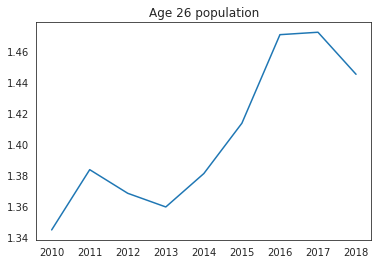

In [13]:
# sanity check
(pop_data_2010[26]*100./pop_data_2010['total']).plot()
_ = plt.title('Age 26 population')

### 2000-2009

In [14]:
# Source url: https://www.census.gov/data/datasets/time-series/demo/popest/intercensal-2000-2010-national.html
POP_DATA_URL_2000 = 'https://www2.census.gov/programs-surveys/popest/datasets/2000-2010/intercensal/national/us-est00int-alldata.csv'

In [15]:
pop_data_2000_raw = pd.read_csv(POP_DATA_URL_2000, index_col=None, header=0)

# Estimates are available for April and July (??), I use July.
pop_data_2000 = pop_data_2000_raw[pop_data_2000_raw['MONTH'] == 7]

In [16]:
def download_2000_pop_data(pop_data_url_2000=POP_DATA_URL_2000, month=7):
    """
    Download population data from 2000-2009
    Estimates are available for July, and also for April only in 2000 and 2010 (??), so I use July.
    """   
    # Download
    pop_data_2000_raw = pd.read_csv(pop_data_url_2000, index_col=None, header=0)
    
    # Estimates are available for April and July (??), I use July.
    pop_data_2000 = pop_data_2000_raw[pop_data_2000_raw['MONTH'] == month]

    # Clean
    def clean_pop_2000(df):
        df = df.rename(columns={999: 'total'})
        df.index.name = None
        df.columns.name = None
        return df

    pop_data_2000_total = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_POP')
    pop_data_2000_male = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_MALE')
    pop_data_2000_female = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_FEMALE')

    pop_data_2000_total = clean_pop_2000(pop_data_2000_total)
    pop_data_2000_male = clean_pop_2000(pop_data_2000_male)
    pop_data_2000_female = clean_pop_2000(pop_data_2000_female)
    
    # Return
    return pop_data_2000_total, pop_data_2000_male, pop_data_2000_female

In [17]:
def load_pop_data_2000(pop_data_url_2000=POP_DATA_URL_2000, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_2000_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_2000_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_2000_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_2000_total = pd.read_csv(total_filename, index_col=0)
        pop_data_2000_total.columns = [int(x) for x in pop_data_2000_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 2000-2009 population data"
        pop_data_2000_total, males, females = download_2000_pop_data(pop_data_url_2000)
        
        pop_data_2000_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_2000_total

In [18]:
pop_data_2000 = load_pop_data_2000()

Loading other_data/pop_data_2000_total.csv


### 1990-2000

In [19]:
#https://www.census.gov/data/datasets/time-series/demo/popest/intercensal-1990-2000-national.html
POP_DATA_URL_1990 = 'https://www2.census.gov/programs-surveys/popest/datasets/1990-2000/intercensal/national/us-est90int-07.csv'

In [20]:
def download_1990_pop_data(pop_data_url_1990=POP_DATA_URL_1990, month=7):
    """
    Download population data from 1990-1999
    Estimates are available monthly, I use July.
    """   
    # Download
    pop_data_1990_raw = pd.read_csv(pop_data_url_1990, index_col=None, header=0, skiprows=1)
    
    # Clean
    # Relabel columns
    pop_data_1990 = pop_data_1990_raw.copy()
    pop_data_1990.columns = ['Date', 'Age', 'Total', 'Male', 'Female']
    # Drop bad rows
    pop_data_1990 = pop_data_1990['Int' != pop_data_1990['Date'].str[:3]]
    # Date
    pop_data_1990['Date'] = pd.to_datetime(pop_data_1990['Date'])
    pop_data_1990['Year'] = pop_data_1990['Date'].apply(lambda x: x.year)
    pop_data_1990['Month'] = pop_data_1990['Date'].apply(lambda x: x.month)
    # Age
    pop_data_1990['Age'] = pop_data_1990['Age'].replace('100+', '100')
    pop_data_1990['Age'] = pop_data_1990['Age'].replace('All Age', 'total')
    # Estimates are available quarterly, I use April.
    pop_data_1990 = pop_data_1990[pop_data_1990['Month'] == month]
    
    # Collect
    pop_data_1990_total = pd.pivot_table(pop_data_1990, index='Year', columns='Age', values='Total')
    pop_data_1990_male = pd.pivot_table(pop_data_1990, index='Year', columns='Age', values='Male')
    pop_data_1990_female = pd.pivot_table(pop_data_1990, index='Year', columns='Age', values='Female')
    
    # Clean moar
    def clean_pop_1990(df):
        df.index.name = None
        df.columns.name = None
        df.columns = [int(x) if x != 'total' else 'total' for x in df.columns]
        order = sorted(df.columns)
        return df[order]
    pop_data_1990_total = clean_pop_1990(pop_data_1990_total)
    pop_data_1990_male = clean_pop_1990(pop_data_1990_male)
    pop_data_1990_female = clean_pop_1990(pop_data_1990_female)
    
    # Return
    return pop_data_1990_total, pop_data_1990_male, pop_data_1990_female

In [21]:
def load_pop_data_1990(pop_data_url_1990=POP_DATA_URL_1990, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_1990_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_1990_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_1990_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_1990_total = pd.read_csv(total_filename, index_col=0)
        pop_data_1990_total.columns = [int(x) for x in pop_data_1990_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 1990-1999 population data"
        pop_data_1990_total, males, females = download_1990_pop_data(pop_data_url_1990)
        
        pop_data_1990_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_1990_total

In [22]:
pop_data_1990 = load_pop_data_1990()

Loading other_data/pop_data_1990_total.csv


### 1980-1990

In [23]:
# Source: https://www.census.gov/data/datasets/time-series/demo/popest/1980s-national.html
# Documentation: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/1980-1990/nat-detail-layout.txt
POP_DATA_URLS_1980s = {
    1980: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8081rqi.zip',
    1981: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8182rqi.zip',
    1982: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8283rqi.zip',
    1983: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8384rqi.zip',
    1984: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8485rqi.zip',
    1985: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8586rqi.zip',
    1986: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8687rqi.zip',
    1987: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8788rqi.zip',
    1988: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8889rqi.zip',
    1989: 'https://www2.census.gov/programs-surveys/popest/datasets/1980-1990/national/asrh/e8990rqi.zip',
}

In [24]:
def download_1980_pop_data_by_year(year, pop_data_urls_1980s=POP_DATA_URLS_1980s, 
                                   other_data_dest_base=OTHER_DATA_DEST_BASE, month=7):
    """
    Download population data for a given year in 1980-1989
    Estimates are available quarterly, I use July.
    """   
    # Download zip for the year
    url = pop_data_urls_1980s[year]
    r = requests.get(url, stream=True)
    with zipfile.ZipFile(StringIO.StringIO(r.content)) as zf:
        zf.extractall(other_data_dest_base)    
    
    # Read in data (stored as a string wtf)
    year_str2 = str(year)[-2:]
    year_after_str2 = str(year+1)[-2:]
    raw_data_name = 'E{0}{1}RQI.TXT'.format(year_str2, year_after_str2)
    raw_data_path = os.path.join(other_data_dest_base, raw_data_name)
    raw_data = open(raw_data_path, 'r').readlines()

    pop_data_year = {
        'Month': {},
        'Year': {},
        'Age': {},
        'Total': {},
        'Male': {},
        'Female': {},
    }
    for row_num in range(len(raw_data)):
        row = raw_data[row_num]
        if len(row) < 40:
            continue
        #pop_data_year['series'][row_num] = row[0:2]
        pop_data_year['Month'][row_num] = int(row[2:4])
        pop_data_year['Year'][row_num] = int('19' + row[4:6])
        pop_data_year['Age'][row_num] = int(row[6:10])
        #pop_data_year['blank'][row_num] = row[10:11]
        pop_data_year['Total'][row_num] = int(row[11:21])
        pop_data_year['Male'][row_num] = int(row[21:31])
        pop_data_year['Female'][row_num] = int(row[31:41])
    
    # Clean up
    pop_data_year = pd.DataFrame(pop_data_year)
    os.remove(raw_data_path)
    
    # Clean
    pop_data_year['Age'] = pop_data_year['Age'].replace(999, 'total')
    pop_data_year = pop_data_year[pop_data_year['Year'] == year]
    pop_data_year = pop_data_year[pop_data_year['Month'] == month]

    
    return pop_data_year

In [25]:
def download_1980_pop_data(pop_data_urls_1980s=POP_DATA_URLS_1980s, 
                           other_data_dest_base=OTHER_DATA_DEST_BASE, month=7):
    """
    Download population data from 1980-1989
    Estimates are available monthly, I use July.
    """   
    # Download
    pop_data_1980_dict = {}
    for year in range(1980, 1990):
        pop_data_1980_dict[year] = download_1980_pop_data_by_year(year, pop_data_urls_1980s, 
                                                                  other_data_dest_base, month)
    pop_data_1980 = pd.concat(pop_data_1980_dict.values(), axis=0)
        
    # Collect
    pop_data_1980_total = pd.pivot_table(pop_data_1980, index='Year', columns='Age', values='Total')
    pop_data_1980_male = pd.pivot_table(pop_data_1980, index='Year', columns='Age', values='Male')
    pop_data_1980_female = pd.pivot_table(pop_data_1980, index='Year', columns='Age', values='Female')
    
    # Clean moar
    def clean_pop_1980(df):
        df.index.name = None
        df.columns.name = None
        df.columns = [int(x) if x != 'total' else 'total' for x in df.columns]
        order = sorted(df.columns)
        return df[order]
    pop_data_1980_total = clean_pop_1980(pop_data_1980_total)
    pop_data_1980_male = clean_pop_1980(pop_data_1980_male)
    pop_data_1980_female = clean_pop_1980(pop_data_1980_female)
    
    # Return
    return pop_data_1980_total, pop_data_1980_male, pop_data_1980_female

In [26]:
def load_pop_data_1980(pop_data_urls_1980s=POP_DATA_URLS_1980s, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_1980_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_1980_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_1980_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_1980_total = pd.read_csv(total_filename, index_col=0)
        pop_data_1980_total.columns = [int(x) for x in pop_data_1980_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 1990-1999 population data"
        pop_data_1980_total, males, females = download_1980_pop_data(pop_data_urls_1980s, other_data_dest_base)
        
        pop_data_1980_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_1980_total

In [27]:
pop_data_1980 = load_pop_data_1980()

Loading other_data/pop_data_1980_total.csv


### <1980

In [28]:
#https://www.census.gov/data/tables/time-series/demo/popest/pre-1980-national.html

### Combine

In [29]:
# Note that the "max bucket" varies over time, but doesn't matter for our purposes
# See https://www.census.gov/dataviz/visualizations/055/

In [30]:
dict_of_pop_data = {
    '2010-2017': pop_data_2010,
    '2000-2009': pop_data_2000.loc[2000:2009],
    '1990-1999': pop_data_1990,
    '1980-1989': pop_data_1980,
    #'<1980': None,
}

In [31]:
pop_data = pd.concat(dict_of_pop_data.values(), axis=0)
pop_data = pop_data.fillna(0)
pop_data = pop_data.sort_index()

clear_output() # stupid warning

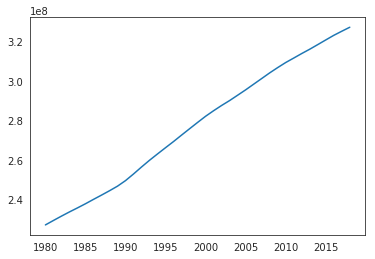

In [32]:
# Sanity check
pop_data['total'].plot()

In [33]:
# Save
pop_data.to_csv(os.path.join(OTHER_DATA_DEST_BASE, 'pop_data.csv'))

# Get just suicide data

In [12]:
CLEAN_DATA_BASE = 'cleaned_data'

In [13]:
if not os.path.exists(CLEAN_DATA_BASE):
    os.makedirs(CLEAN_DATA_BASE)
    print "Created", CLEAN_DATA_BASE

In [14]:
# See Hansen and Lang (2011), "Data" section; or individual documentation files linked from NBER
DEATH_VAR_MAP = {}
SUICIDE_VAL_MAP = {}
#for year in range(1968, 1979):
    # ICDA-8
    # https://www.nber.org/mortality/www.cdc.gov/nchs/data/dvs/dt78icd8.pdf
    #DEATH_VAR_MAP[year] = 'ucr34'
    #SUICIDE_VAL_MAP[year] = 350
for year in range(1979, 1999):
    # ICDA-9
    # https://www.nber.org/mortality/1998/desc_mort1998.txt
    DEATH_VAR_MAP[year] = 'ucr34'
    SUICIDE_VAL_MAP[year] = 350
for year in range(1999, 2018):
    # ICDA-10
    # https://www.nber.org/mortality/1999/desc_mort1999.txt
    DEATH_VAR_MAP[year] = 'ucr39'
    SUICIDE_VAL_MAP[year] = 40

In [15]:
def get_suicide_data(death_var_map=DEATH_VAR_MAP, suicide_val_map=SUICIDE_VAL_MAP,
                     start_year=START_YEAR, end_year=END_YEAR,
                     raw_data_loc_base=DOWNLOAD_DEST_BASE, suicide_data_loc_base=CLEAN_DATA_BASE):
    for year in reversed(range(start_year, end_year+1)):
        # Check if already exists
        new_filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
        if os.path.exists(new_filename):
            print new_filename, "already exists"
            continue

        # Set appropriate variables
        death_var = death_var_map[int(year)]
        suicide_val = suicide_val_map[int(year)]
        
        # Get data
        get_suicide_data_by_year(death_var, suicide_val, year, raw_data_loc_base, suicide_data_loc_base)

In [16]:
def get_suicide_data_by_year(death_var, suicide_val, year,
                             raw_data_loc_base=DOWNLOAD_DEST_BASE, suicide_data_loc_base=CLEAN_DATA_BASE):
    # Check if already exists
    new_filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
    if os.path.exists(new_filename):
        print new_filename, "already exists"
        return

    # Load data
    print "Loading", year
    filename = os.path.join(raw_data_loc_base, '{0}.csv'.format(year))
    data = pd.read_csv(filename)

    # Filter to just suicides
    suicide_data = data[data[death_var] == suicide_val]

    # Extract age
    if (year <= 2002) & (year >= 1979):    # this might work for prior to 1979 as well, but haven't checked codebooks
        # See "Detail Age": https://www.nber.org/mortality/2002/mort2002.pdf
        # above 99 label as 100
        suicide_data.loc[(suicide_data['age'] > 100) & (suicide_data['age'] < 200), 'age'] = 100
        # months/weeks/days/hours/minutes report as 0
        suicide_data.loc[(suicide_data['age'] > 200) & (suicide_data['age'] < 700), 'age'] = 0
        # drop unknowns
        clean_suicide_data = suicide_data[suicide_data['age'] != 999]
    elif year >= 2003:
        # See "Detail Age": https://www.nber.org/mortality/2003/mort2003.pdf
        age_in_years = (suicide_data['age'] > 1000) & (suicide_data['age'] < 2000)
        age_zero = (suicide_data['age'] > 2000) & (suicide_data['age'] < 7000)
        not_missing = suicide_data['age'] != 9999
        # get age for 1+
        suicide_data.loc[age_in_years, 'age'] -= 1000
        # months/weeks/days/hours/minutes report as 0
        suicide_data.loc[age_zero, 'age'] = 0
        # above 99 label as 100
        suicide_data.loc[(suicide_data['age'] > 100) & not_missing, 'age'] = 100
        # drop unknowns
        clean_suicide_data = suicide_data.loc[not_missing]

    # Drop irrelevant vars
    final_suicide_data = clean_suicide_data[['sex', 'age', 'monthdth']].copy()
    final_suicide_data = final_suicide_data.rename(columns={'monthdth': 'month'})
    final_suicide_data['year'] = year

    # Get sex
    # TODO: ...confirm
    # final_suicide_data['sex'].replace(1, 'M').replace(2, 'F')

    # Save data
    final_suicide_data.to_csv(new_filename)
    print "Saved", new_filename

In [17]:
get_suicide_data()

cleaned_data/2017.csv already exists
cleaned_data/2016.csv already exists
cleaned_data/2015.csv already exists
cleaned_data/2014.csv already exists
cleaned_data/2013.csv already exists
cleaned_data/2012.csv already exists
cleaned_data/2011.csv already exists
cleaned_data/2010.csv already exists
cleaned_data/2009.csv already exists
cleaned_data/2008.csv already exists
cleaned_data/2007.csv already exists
cleaned_data/2006.csv already exists
cleaned_data/2005.csv already exists
cleaned_data/2004.csv already exists
cleaned_data/2003.csv already exists
cleaned_data/2002.csv already exists
cleaned_data/2001.csv already exists
cleaned_data/2000.csv already exists
cleaned_data/1999.csv already exists
cleaned_data/1998.csv already exists
cleaned_data/1997.csv already exists
cleaned_data/1996.csv already exists
cleaned_data/1995.csv already exists
cleaned_data/1994.csv already exists
cleaned_data/1993.csv already exists
cleaned_data/1992.csv already exists
cleaned_data/1991.csv already exists
c

In [18]:
# example
df = pd.read_csv('cleaned_data/2017.csv', index_col=0)
df.sample(n=5)

,sex,age,month,year
603638,M,84,6,2017
1422674,M,26,5,2017
1099151,M,45,2,2017
561468,M,21,4,2017
1017981,M,36,12,2017


In [19]:
# example
df = pd.read_csv('cleaned_data/1992.csv', index_col=0)
df.sample(n=5)

,sex,age,month,year
203249,1,51,5,1992
1076072,1,80,12,1992
1142667,1,60,10,1992
612058,1,65,4,1992
1337959,1,66,9,1992


# Get deaths of despair 

In [41]:
# TODO

In [ ]:
ICD_VAR_MAP = {}
# ICD 9 -- DOUBLE CHECK START AND END DATE, RAFKIN CONFLICTS
for i in range(1979, 2000):
    ICD_VAR_MAP[i] = 'ucod'
# ICD 10 -- DOUBLE CHECK START AND END DATE
for i in range(2000, 2018):
    ICD_VAR_MAP[i] = 'ucod'

In [ ]:
# ICD 9
ICD_9_MAP = {}
for i in range(1400, 2090):
    ICD_9_MAP[i] = 'Cancer'
for i in range(3900, 4300):
    ICD_9_MAP[i] = 'Heart disease'
for i in range(8000, 10000):
    if i not in range(570, 580) + range(8500, 8610) + range(9500, 9600) + range(9800, 9810):
        ICD_9_MAP[i] = 'Injuries'
# Despair
for i in range(570, 580):
    ICD_9_MAP[i] = 'Despair'
for i in range(8500, 8610):
    ICD_9_MAP[i] = 'Despair'
for i in range(9500, 9600):
    ICD_9_MAP[i] = 'Despair'
for i in range(9800, 9810):
    ICD_9_MAP[i] = 'Despair'
# Other
for i in range(1, 10001):
    if i not in ICD_9_MAP:
        ICD_9_MAP[i] = 'Other diseases'

In [ ]:
# Source:
# Deaths of despair: https://www.brookings.edu/wp-content/uploads/2017/03/casedeaton_sp17_dataappendix.pdf
# "Injuries" from Novosad-Rafkin fwiw
# ICD 10
ICD_10_MAP = {}
# Cancer
for i in range(0, 980):
    ICD_10_MAP['C' + str(i)] = 'Cancer'
    ICD_10_MAP['C0' + str(i)] = 'Cancer'
    ICD_10_MAP['C00' + str(i)] = 'Cancer'
# Heart disease -- todo: not sure if I'm actually coding this correctly with all the silly zeros...
for i in range(0, 100):
    ICD_10_MAP['I' + str(i)] = 'Heart disease'
    ICD_10_MAP['I0' + str(i)] = 'Heart disease'
    ICD_10_MAP['I00' + str(i)] = 'Heart disease'
for i in range(110, 120):
    ICD_10_MAP['I' + str(i)] = 'Heart disease'
for i in range(130, 140):
    ICD_10_MAP['I' + str(i)] = 'Heart disease'
for i in range(200, 520):
    ICD_10_MAP['I' + str(i)] = 'Heart disease'
# Injuries
for i in range(0, 1001):
    for letter in ['V', 'W', 'X', 'Y']:
        if letter + str(i) not in ICD_10_MAP:
            ICD_10_MAP[letter + str(i)] = 'Injuries'
        if letter + '0' + str(i) not in ICD_10_MAP:
            ICD_10_MAP[letter + '0' + str(i)] = 'Injuries'
        if letter + '00' + str(i) not in ICD_10_MAP:
            ICD_10_MAP[letter + '00' + str(i)] = 'Injuries'
# Deaths of despair
# Poisoning
for i in range(400, 460):
    ICD_10_MAP['X' + str(i)] = 'Poisoning'
for i in range(100, 150):
    ICD_10_MAP['Y' + str(i)] = 'Poisoning'
for i in range(450, 460):
    ICD_10_MAP['Y' + str(i)] = 'Poisoning'
for i in range(470, 480):
    ICD_10_MAP['Y' + str(i)] = 'Poisoning'
for i in range(490, 500):
    ICD_10_MAP['Y' + str(i)] = 'Poisoning'
# Suicide
for i in range(600, 850):
    ICD_10_MAP['X' + str(i)] = 'Suicide'
for i in range(870, 880):
    ICD_10_MAP['Y' + str(i)] = 'Suicide'
# Liver disease
for i in range(700, 710):
    ICD_10_MAP['K' + str(i)] = 'Liver disease'
for i in range(730, 750):
    ICD_10_MAP['K' + str(i)] = 'Liver disease'

In [ ]:
test_filename1992 = os.path.join(DOWNLOAD_DEST_BASE, '1992.csv')
test_data1992 =  pd.read_csv(test_filename1992)

In [ ]:
test_filename2015 = os.path.join(DOWNLOAD_DEST_BASE, '2015.csv')
test_data2015 = pd.read_csv(test_filename2015)

# Group by age and compute suicide rates

### Stack suicide data

In [20]:
START_YEAR = 1980
# 1980 not 1979 until we get population data for then

In [21]:
def stack_suicide_data(start_year=START_YEAR, end_year=END_YEAR, suicide_data_loc_base=CLEAN_DATA_BASE):
    data = {}
    for year in range(start_year, end_year+1):
        filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
        data[year] = pd.read_csv(filename, index_col=0)
        
    stacked_data = pd.concat(data.values(), axis=0)
    return stacked_data, data

In [22]:
suicide_data, tmp = stack_suicide_data()

In [23]:
suicide_data.sample(n=5)

,sex,age,month,year
44498,1,30,6,2002
375369,M,44,7,2009
1764919,M,53,6,2006
980930,M,35,9,2008
1429876,1,40,3,1984


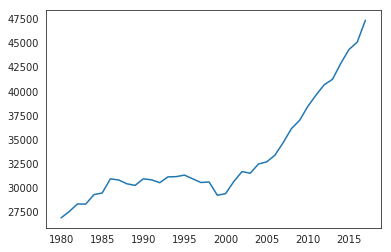

In [24]:
# jfc
suicide_data['year'].value_counts().sort_index().plot()

### Group suicide data by age

In [25]:
AGE_GROUPS = {
    '<14': range(0, 14),
    '14-18': range(14, 19),
    '19-25': range(19, 26),
    '>25': range(26, 101)
}

# alternative 1:
#AGE_GROUPS = {
#    '<18': range(0, 18),
#    '>=18': range(18, 101),
#}

# alternative 2:
#AGE_GROUPS = {
#    '<18': range(0, 18),
#    '18-25': range(18, 26),
#    '26+': range(26, 101)
#}

# alternative 3:
#AGE_GROUPS = {
#    '<6': range(6),
#    '07': [7],
#    '08': [8],
#    '09': [9],
#    '>60': range(61, 101)
#}
#for i in range(10, 61):
#    AGE_GROUPS[str(i)] = [i]

In [26]:
def get_age_order(age_groups):
    first_val = [k for k in age_groups if '<' in k]
    last_val = [k for k in age_groups if '>' in k]
    other = [k for k in age_groups if k not in first_val and k not in last_val]
    other = sorted(other)
    return first_val + other + last_val
# should output ['<15', '15-18', '19-25', '>25']
GROUP_ORDER = get_age_order(AGE_GROUPS)

In [27]:
def get_age_groups_map(age_groups):
    return {
        v: k
        for k in age_groups
        for v in age_groups[k]
    }
AGE_GROUPS_MAP = get_age_groups_map(AGE_GROUPS)

In [28]:
suicide_data['age_group'] = suicide_data['age'].map(AGE_GROUPS_MAP)

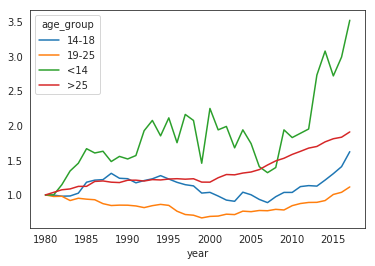

In [29]:
# :(((((((((((((
tmp = pd.pivot_table(data=suicide_data[['age_group', 'year']], index='year', columns='age_group', aggfunc=len)
(tmp/tmp.loc[1980]).plot()

In [30]:
suicide_counts_by_age_group_by_monthyear = (
    suicide_data[['year', 'month', 'age_group']]
    .groupby(['year', 'month', 'age_group'])
    .apply(len)
    .unstack()
    .fillna(0)
)

In [31]:
# preview
suicide_counts_by_age_group_by_monthyear.head()

age_group   14-18  19-25   <14     >25
year month                            
1980 1      114.0  377.0   7.0  1650.0
     2      102.0  376.0   8.0  1570.0
     3      112.0  401.0  10.0  1772.0
     4       86.0  391.0   9.0  1848.0
     5      103.0  367.0   4.0  1846.0

### Group population data by age

In [32]:
pop_by_group = pd.DataFrame()
for group_k, group_v in AGE_GROUPS.iteritems():
    pop_by_group[group_k] = pop_data[group_v].sum(1)
pop_by_group = pop_by_group[GROUP_ORDER]
pop_by_group.index.name = 'year'

In [33]:
blank_df = pd.DataFrame(index=suicide_counts_by_age_group_by_monthyear.index)
pop_by_group_by_monthyear = blank_df.join(pop_by_group)

In [34]:
# preview
pop_by_group_by_monthyear.head()

<14       14-18       19-25          >25
year month                                                 
1980 1      47540375.0  20372913.0  30006209.0  129305184.0
     2      47540375.0  20372913.0  30006209.0  129305184.0
     3      47540375.0  20372913.0  30006209.0  129305184.0
     4      47540375.0  20372913.0  30006209.0  129305184.0
     5      47540375.0  20372913.0  30006209.0  129305184.0

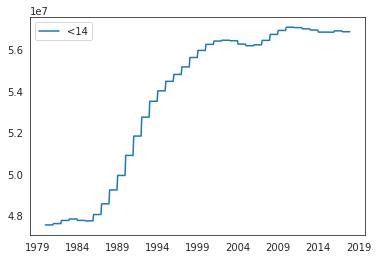

In [35]:
# preview
tmp_index = [pd.datetime(x[0], x[1], 1) for x in pop_by_group_by_monthyear.index]
tmp = pop_by_group_by_monthyear.copy()
tmp.index = tmp_index
tmp[['<14']].plot()

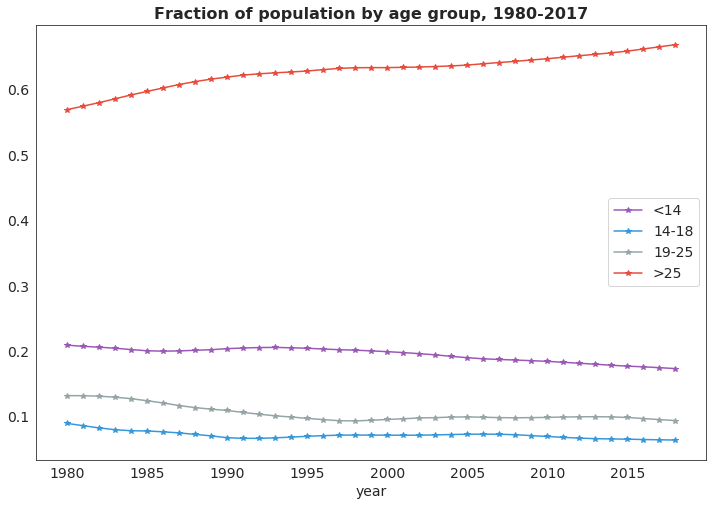

In [38]:
# population share trends
age_group_shares = pop_by_group.divide(pop_by_group.sum(1), axis=0)

age_group_shares.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Fraction of population by age group, {0}-{1}'.format(START_YEAR, END_YEAR), fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.legend(fontsize=14)
plt.savefig('figures/age_shares.png', dpi=300, bbox_inches='tight')

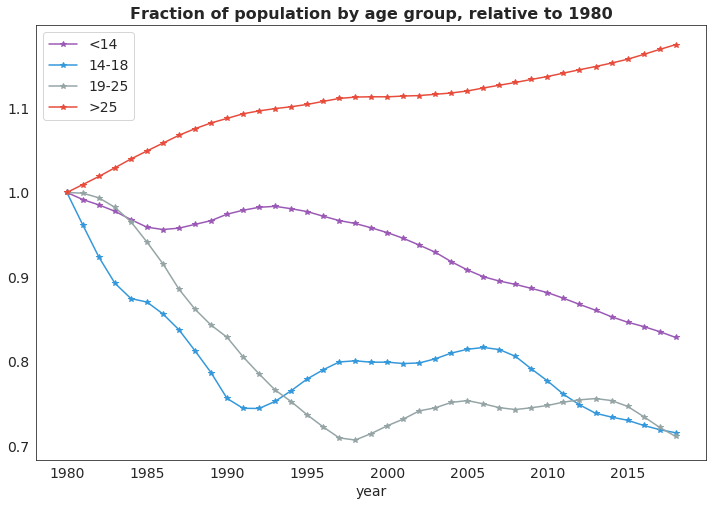

In [39]:
# population share relative to 1980
(age_group_shares/age_group_shares.loc[1980]).plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Fraction of population by age group, relative to 1980', fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.legend(fontsize=14)
plt.savefig('figures/age_shares_relative_to_1980.png', dpi=300, bbox_inches='tight')

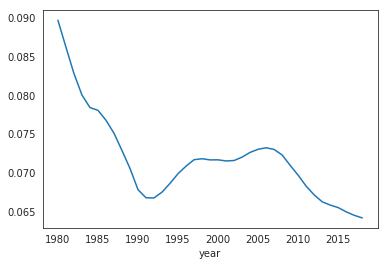

In [40]:
age_group_shares['14-18'].plot()

### Normalize suicide data by population data

In [41]:
# Get data by month-year
suicide_rate_by_monthyear = suicide_counts_by_age_group_by_monthyear/pop_by_group_by_monthyear

raw_suicide_rate_per100k_annualized_by_monthyear = suicide_rate_by_monthyear[GROUP_ORDER]*12*100000

In [42]:
new_index = [
    pd.datetime(x[0], x[1], 1) 
    for x 
    in raw_suicide_rate_per100k_annualized_by_monthyear.index
]
suicide_rate_per100k_annualized_by_monthyear = raw_suicide_rate_per100k_annualized_by_monthyear.copy()
suicide_rate_per100k_annualized_by_monthyear.index = new_index

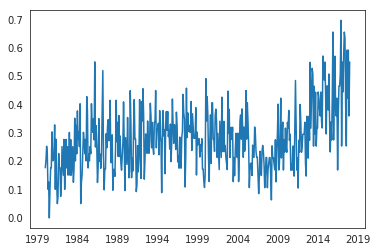

In [43]:
suicide_rate_per100k_annualized_by_monthyear['<14'].plot()

### Group by time unit

In [44]:
tmp = raw_suicide_rate_per100k_annualized_by_monthyear.reset_index()

In [45]:
# Get by month
suicide_rate_per100k_annualized_by_month = tmp.groupby('month').mean()[GROUP_ORDER]
# preview
suicide_rate_per100k_annualized_by_month.head()

,<14,14-18,19-25,>25
month,,,,
1,0.312700,8.216491,14.341247,15.720151
2,0.299155,7.396194,12.788402,14.414260
3,0.335024,7.985141,14.361181,16.483837
4,0.300675,7.763719,14.093155,16.239275
5,0.295646,7.627150,14.330608,16.784793


In [46]:
# Get by year
suicide_rate_per100k_by_year = tmp.groupby('year').sum()[GROUP_ORDER]/12

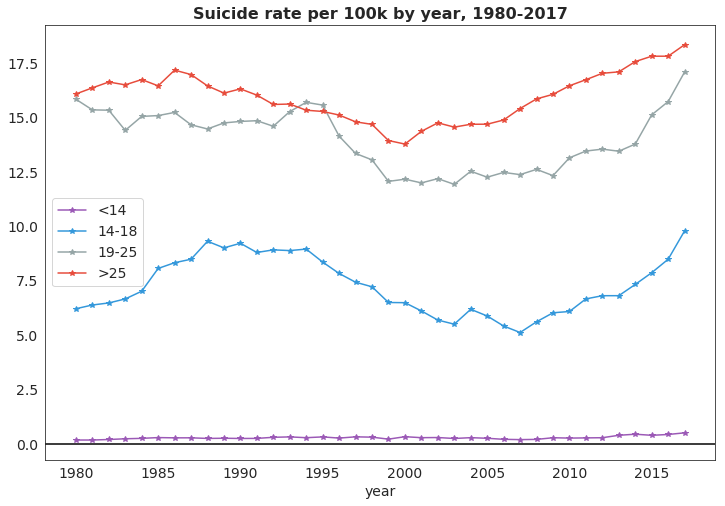

In [47]:
suicide_rate_per100k_by_year.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Suicide rate per 100k by year, {0}-{1}'.format(START_YEAR, END_YEAR), fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.axhline(0.0, color='k')
_ = plt.legend(fontsize=14)
if SAVE_FIGS:
    plt.savefig('figures/suicide_rate_by_year.png', dpi=300, bbox_inches='tight')

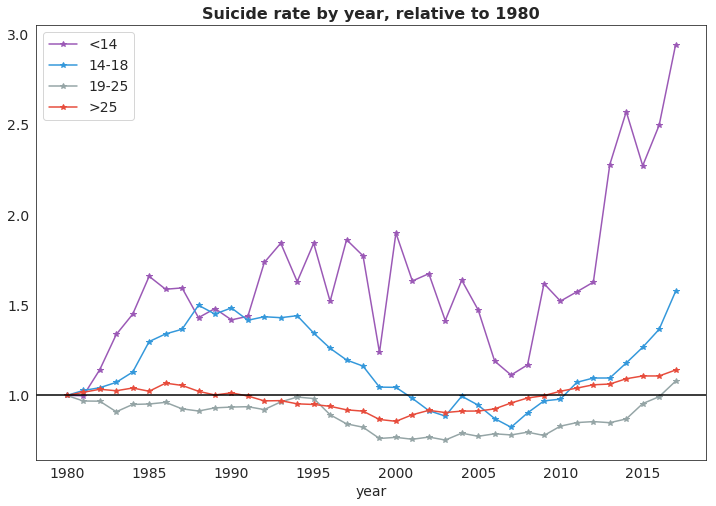

In [48]:
(
    suicide_rate_per100k_by_year/suicide_rate_per100k_by_year.loc[1980]
).plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Suicide rate by year, relative to 1980', fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.axhline(1.0, color='k')
_ = plt.legend(fontsize=14)
if SAVE_FIGS:
    plt.savefig('figures/suicide_rate_rel_to_1980.png', dpi=300, bbox_inches='tight')

# Plotting rates

### Setup

In [49]:
year_range_str = ', ' + str(START_YEAR) + '-' + str(END_YEAR)

In [50]:
months_map = {
    1: 'Jan.',
    2: 'Feb.',
    3: 'Mar.',
    4: 'Apr.',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'Aug.',
    9: 'Sep.',
    10: 'Oct.',
    11: 'Nov.',
    12: 'Dec.',
}

### All at once

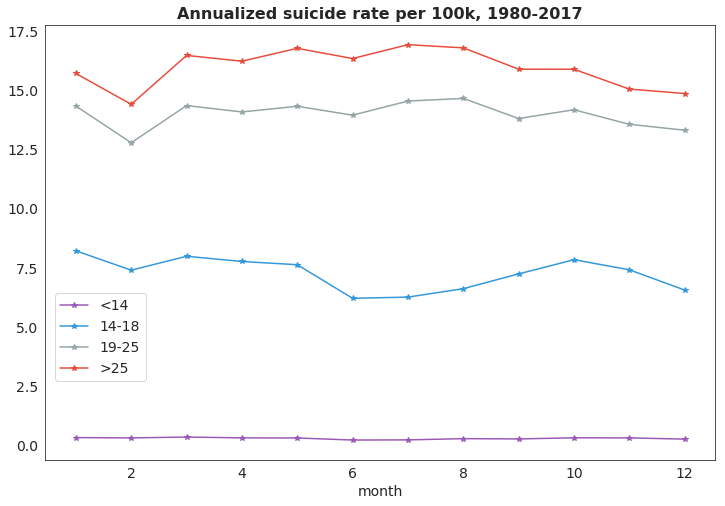

In [51]:
suicide_rate_per100k_annualized_by_month.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Annualized suicide rate per 100k' + year_range_str, fontsize=16, weight='bold')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('month', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.legend(fontsize=14, bbox_to_anchor=[0.16, 0.4])
#_ = plt.axhline(1.0, color='gray')
if SAVE_FIGS:
    plt.savefig('figures/suicide_rate_by_month.png', dpi=300, bbox_inches='tight')

### Normalized

In [52]:
# Set 'normalize_by_mean = True' if you want to normalize relative to whole-year average
# Set 'normalize_by_month = INTEGER' if you want to normalize relative to a specific month
normalize_by_mean = True
normalize_by_month = 0

if (normalize_by_mean > 0) and (normalize_by_month > 0):
    print "Pick only one option silly"
    
if normalize_by_mean:
    title_str = 'relative to whole-year'
if normalize_by_month > 0:
    month_str = months_map[normalize_by_month]
    title_str = 'relative to {0}'.format(month_str)

In [53]:
if normalize_by_mean:
    rel = (
        suicide_rate_per100k_annualized_by_month
        /suicide_rate_per100k_annualized_by_month.mean()
    )
elif normalize_by_month > 0:
    rel = (
        suicide_rate_per100k_annualized_by_month
        /suicide_rate_per100k_annualized_by_month.loc[normalize_by_month]
    )
rel = rel.rename(index=months_map)

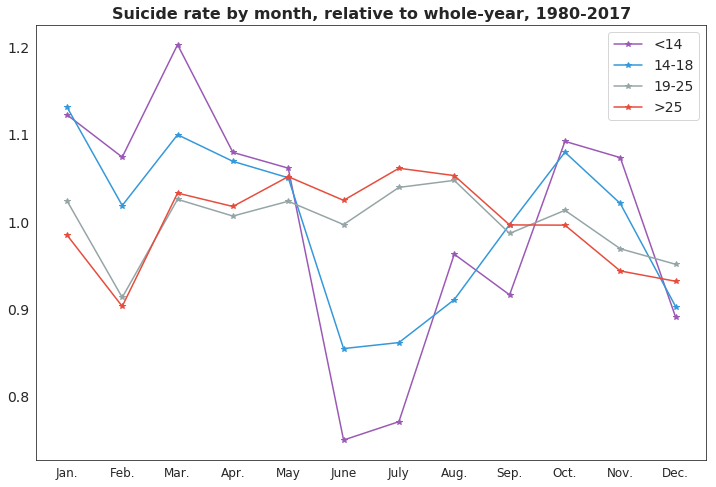

In [54]:
#fig, ax = plt.subplots(1)
rel.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Suicide rate by month, ' + title_str + year_range_str, fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('', fontsize=14)
_ = plt.xticks(range(len(rel.index)), rel.index, fontsize=12)
_ = plt.yticks(fontsize=14)
_ = plt.legend(fontsize=14)
#_ = plt.axhline(1.0, color='gray')
if SAVE_FIGS:
    if normalize_by_mean:
        plt.savefig('figures/suicide_rate_by_month_relative_to_mean.png', dpi=300, bbox_inches='tight')
    if normalize_by_month > 0:
        filename = 'figures/suicide_rate_by_month_relative_to_{0}.png'.format(months_map[normalize_by_month])
        plt.savefig(filename, dpi=300, bbox_inches='tight')

In [55]:
suicide_rate_per100k_annualized_by_month

,<14,14-18,19-25,>25
month,,,,
1,0.312700,8.216491,14.341247,15.720151
2,0.299155,7.396194,12.788402,14.414260
3,0.335024,7.985141,14.361181,16.483837
4,0.300675,7.763719,14.093155,16.239275
5,0.295646,7.627150,14.330608,16.784793
6,0.208915,6.206840,13.956476,16.351430
7,0.214776,6.256686,14.552543,16.938187
8,0.268198,6.613622,14.665370,16.804077
9,0.255227,7.237952,13.814473,15.902554


# Regressing

### Set up data

In [56]:
# preview
suicide_rate_per100k_annualized_by_monthyear.head()

,<14,14-18,19-25,>25
1980-01-01,0.176692,6.714798,15.076880,15.312611
1980-02-01,0.201934,6.007977,15.036888,14.570182
1980-03-01,0.252417,6.596995,16.036681,16.444816
1980-04-01,0.227175,5.065550,15.636764,17.150124
1980-05-01,0.100967,6.066879,14.676962,17.131564


In [57]:
df = suicide_rate_per100k_annualized_by_monthyear.copy()
df['year_month'] = [pd.datetime.strftime(x, '%Y-%m') for x in df.index]

In [58]:
# preview
df.head()

,<14,14-18,19-25,>25,year_month
1980-01-01,0.176692,6.714798,15.076880,15.312611,1980-01
1980-02-01,0.201934,6.007977,15.036888,14.570182,1980-02
1980-03-01,0.252417,6.596995,16.036681,16.444816,1980-03
1980-04-01,0.227175,5.065550,15.636764,17.150124,1980-04
1980-05-01,0.100967,6.066879,14.676962,17.131564,1980-05


In [59]:
df = (
    df
    .set_index('year_month')
    .stack()
    .reset_index()
    .rename(columns={
        'level_1': 'age_group',
        0: 'suicide_rate_per100k_annualized'
    })
)
df['year'] = df['year_month'].str[:4]
df['month'] = df['year_month'].str[5:]

In [60]:
df.head()

,year_month,age_group,suicide_rate_per100k_annualized,year,month
0,1980-01,<14,0.176692,1980,01
1,1980-01,14-18,6.714798,1980,01
2,1980-01,19-25,15.076880,1980,01
3,1980-01,>25,15.312611,1980,01
4,1980-02,<14,0.201934,1980,02


In [61]:
SUMMER_MONTHS = ['06', '07', '08']
df['is_summer'] = df['month'].isin(SUMMER_MONTHS)*1.
VACATION_MONTHS = ['06', '07', '08', '12']    # arguably could include February
df['is_vacation'] = df['month'].isin(VACATION_MONTHS)*1.

In [62]:
df.sample(n=5)

,year_month,age_group,suicide_rate_per100k_annualized,year,month,is_summer,is_vacation
586,1992-03,19-25,13.620320,1992,03,0.0,0.0
1652,2014-06,<14,0.337898,2014,06,1.0,1.0
1400,2009-03,<14,0.189801,2009,03,0.0,0.0
551,1991-06,>25,16.815698,1991,06,1.0,1.0
799,1996-08,>25,15.723817,1996,08,1.0,1.0


In [63]:
groups = df['age_group'].unique()
years = df['year'].unique()
dfs_by_group = {
    group: df[df['age_group'] == group]
    for group in groups
}
dfs_by_year = {
    group: {
        year: df[(df['age_group'] == group) & (df['year'] == year)]
        for year in years
    }
    for group in groups
}

### Formulas

In [91]:
BY_MONTH_FML = 'suicide_rate_per100k_annualized ~ C(month, patsy.Treatment(reference="09"))'
BY_MONTH_W_FE_FML = 'suicide_rate_per100k_annualized ~ C(month, patsy.Treatment(reference="09")) + C(year)'
SUMMER_FML = 'suicide_rate_per100k_annualized ~ is_summer'
SUMMER_W_FE_FML = 'suicide_rate_per100k_annualized ~ is_summer + C(year)'
VACATION_FML = 'suicide_rate_per100k_annualized ~ is_vacation'
VACATION_W_FE_FML = 'suicide_rate_per100k_annualized ~ is_vacation + C(year)'

PERCENT_FML = 'np.log(suicide_rate_per100k_annualized + 1) ~ C(month, patsy.Treatment(reference="09"))'
PERCENT_W_FE_FML = 'np.log(suicide_rate_per100k_annualized + 1) ~ C(month, patsy.Treatment(reference="09")) + C(year)'
PCT_SUMMER_FML = 'np.log(suicide_rate_per100k_annualized+1) ~ is_summer'
PCT_SUMMER_W_FE_FML = 'np.log(suicide_rate_per100k_annualized+1) ~ is_summer + C(year)'
PCT_VACATION_FML = 'np.log(suicide_rate_per100k_annualized+1) ~ is_vacation'
PCT_VACATION_W_FE_FML = 'np.log(suicide_rate_per100k_annualized+1) ~ is_vacation + C(year)'

In [66]:
regs_by_month = {}
regs_by_month_w_fe = {}
regs_summer = {}
regs_summer_w_fe = {}
regs_vacation = {}
regs_vacation_w_fe = {}
regs_percent = {}
regs_percent_w_fe = {}

### Whole time period

In [78]:
for group, tmp_df in dfs_by_group.iteritems():
    regs_by_month[group] = sm.formula.ols(data=tmp_df, formula=BY_MONTH_FML).fit()
    regs_by_month_w_fe[group] = sm.formula.ols(data=tmp_df, formula=BY_MONTH_W_FE_FML).fit()
    regs_summer[group] = sm.formula.ols(data=tmp_df, formula=SUMMER_FML).fit()
    regs_summer_w_fe[group] = sm.formula.ols(data=tmp_df, formula=SUMMER_W_FE_FML).fit()
    regs_vacation[group] = sm.formula.ols(data=tmp_df, formula=VACATION_FML).fit()
    regs_vacation_w_fe[group] = sm.formula.ols(data=tmp_df, formula=VACATION_W_FE_FML).fit()
    regs_percent[group] = sm.formula.ols(data=tmp_df, formula=PERCENT_FML).fit()
    regs_percent_w_fe[group] = sm.formula.ols(data=tmp_df, formula=PERCENT_W_FE_FML).fit()

In [79]:
regressor_order = [
    'C(month, patsy.Treatment(reference="09"))[T.01]',
    'C(month, patsy.Treatment(reference="09"))[T.02]',
    'C(month, patsy.Treatment(reference="09"))[T.03]',
    'C(month, patsy.Treatment(reference="09"))[T.04]',
    'C(month, patsy.Treatment(reference="09"))[T.05]',
    'C(month, patsy.Treatment(reference="09"))[T.06]',
    'C(month, patsy.Treatment(reference="09"))[T.07]',
    'C(month, patsy.Treatment(reference="09"))[T.08]',
    'C(month, patsy.Treatment(reference="09"))[T.10]',
    'C(month, patsy.Treatment(reference="09"))[T.11]',
    'C(month, patsy.Treatment(reference="09"))[T.12]',
]

In [80]:
pretty_w_stars = sm.iolib.summary2.summary_col(
    results=regs_by_month_w_fe.values(),
    model_names=regs_by_month_w_fe.keys(),
    regressor_order=regressor_order,
    drop_omitted=True,
    stars=True
)

pretty = sm.iolib.summary2.summary_col(
    results=regs_by_month_w_fe.values(),
    model_names=regs_by_month_w_fe.keys(),
    regressor_order=regressor_order,
    drop_omitted=True,
    stars=False
)

def rename(params_table, months_map=months_map):
    mapping = {}
    for k in params_table.index:
        if 'C(' in k:
            _, month = k.split('[T.')
            month = int(month[:-1])
            mapping[k] = months_map[month]
    return params_table.rename(index=mapping)[GROUP_ORDER]

pretty_w_stars = rename(pretty_w_stars.tables[0])
pretty = rename(pretty.tables[0])

In [81]:
# TODO: SEs here are fucked up. notice they're same for all months for a given age group

In [82]:
pretty_w_stars

,<14,14-18,19-25,>25
Jan.,0.0575***,0.9785***,0.5268**,-0.1824
,(0.0185),(0.1818),(0.2097),(0.1184)
Feb.,0.0439**,0.1582,-1.0261***,-1.4883***
,(0.0185),(0.1818),(0.2097),(0.1184)
Mar.,0.0798***,0.7472***,0.5467***,0.5813***
,(0.0185),(0.1818),(0.2097),(0.1184)
Apr.,0.0454**,0.5258***,0.2787,0.3367***
,(0.0185),(0.1818),(0.2097),(0.1184)
May,0.0404**,0.3892**,0.5161**,0.8822***
,(0.0185),(0.1818),(0.2097),(0.1184)


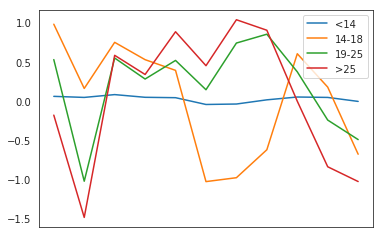

In [83]:
pretty.loc[[k for k in pretty.index if k != '']].astype(float).plot()

In [524]:
# LOTS MORE YOU CAN DO HERE JUST FOR LOOKSIES

In [84]:
print regs_by_month['14-18'].summary()

                                   OLS Regression Results                                  
Dep. Variable:     suicide_rate_per100k_annualized   R-squared:                       0.164
Model:                                         OLS   Adj. R-squared:                  0.143
Method:                              Least Squares   F-statistic:                     7.909
Date:                             Mon, 12 Aug 2019   Prob (F-statistic):           1.33e-12
Time:                                     16:52:04   Log-Likelihood:                -829.58
No. Observations:                              456   AIC:                             1683.
Df Residuals:                                  444   BIC:                             1733.
Df Model:                                       11                                         
Covariance Type:                         nonrobust                                         
                                                      coef    std err          t

In [90]:
print regs_percent['14-18'].summary()

                                         OLS Regression Results                                        
Dep. Variable:     np.log(suicide_rate_per100k_annualized + 1)   R-squared:                       0.169
Model:                                                     OLS   Adj. R-squared:                  0.149
Method:                                          Least Squares   F-statistic:                     8.229
Date:                                         Mon, 12 Aug 2019   Prob (F-statistic):           3.53e-13
Time:                                                 16:52:34   Log-Likelihood:                 140.85
No. Observations:                                          456   AIC:                            -257.7
Df Residuals:                                              444   BIC:                            -208.2
Df Model:                                                   11                                         
Covariance Type:                                     nonrobust  

### By year

In [98]:
regs_by_year = {
    group: {}
    for group in dfs_by_year
}
pct_regs_by_year = {
    group: {}
    for group in dfs_by_year
}

In [94]:
for group in regs_by_year:
    for year in dfs_by_year[group]:
        regs_by_year[group][year] = sm.formula.ols(data=dfs_by_year[group][year], formula=SUMMER_FML).fit()
        pct_regs_by_year[group][year] = sm.formula.ols(data=dfs_by_year[group][year], formula=PCT_SUMMER_FML).fit()

In [95]:
def get_by_year(regs_by_year, func):
    df = {
        group: {
            year: func(regs_by_year[group][year])
            for year in regs_by_year[group]
        }
        for group in regs_by_year
    }
    return df

In [96]:
get_params = lambda x: x.params['is_summer']
get_intercept = lambda x: x.params['Intercept']
get_se = lambda x: x.bse['is_summer']
get_ci = lambda x: x.conf_int().loc['is_summer']

params_by_year = get_by_year(regs_by_year, get_params)
params_by_year = pd.DataFrame(params_by_year)[GROUP_ORDER]
params_by_year.index = pd.to_datetime(params_by_year.index)

intercept_by_year = get_by_year(regs_by_year, get_intercept)
intercept_by_year = pd.DataFrame(intercept_by_year)[GROUP_ORDER]
intercept_by_year.index = pd.to_datetime(intercept_by_year.index)

se_by_year = get_by_year(regs_by_year, get_se)
se_by_year = pd.DataFrame(se_by_year)[GROUP_ORDER]
se_by_year.index = pd.to_datetime(se_by_year.index)

ci_by_year = get_by_year(regs_by_year, get_ci)

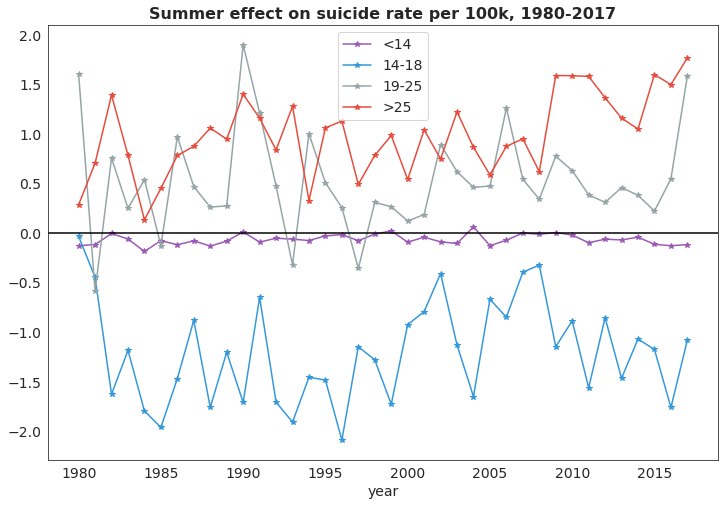

In [97]:
params_by_year.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Summer effect on suicide rate per 100k' + year_range_str, fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.axhline(0.0, color='k')
_ = plt.legend(fontsize=14)
if SAVE_FIGS:
    plt.savefig('figures/summer_coefficient.png', dpi=300, bbox_inches='tight')

In [100]:
pct_params_by_year = get_by_year(pct_regs_by_year, get_params)
pct_params_by_year = pd.DataFrame(pct_params_by_year)[GROUP_ORDER]
pct_params_by_year.index = pd.to_datetime(pct_params_by_year.index)

pct_se_by_year = get_by_year(pct_regs_by_year, get_se)
pct_se_by_year = pd.DataFrame(pct_se_by_year)[GROUP_ORDER]
pct_se_by_year.index = pd.to_datetime(pct_se_by_year.index)

pct_ci_by_year = get_by_year(pct_regs_by_year, get_ci)

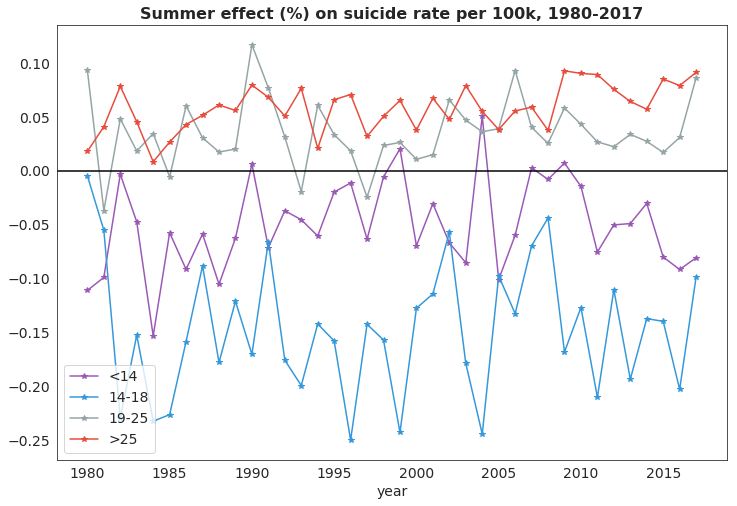

In [102]:
pct_params_by_year.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Summer effect (%) on suicide rate per 100k' + year_range_str, fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.axhline(0.0, color='k')
_ = plt.legend(fontsize=14)
if SAVE_FIGS:
    plt.savefig('figures/summer_pct_coefficient.png', dpi=300, bbox_inches='tight')

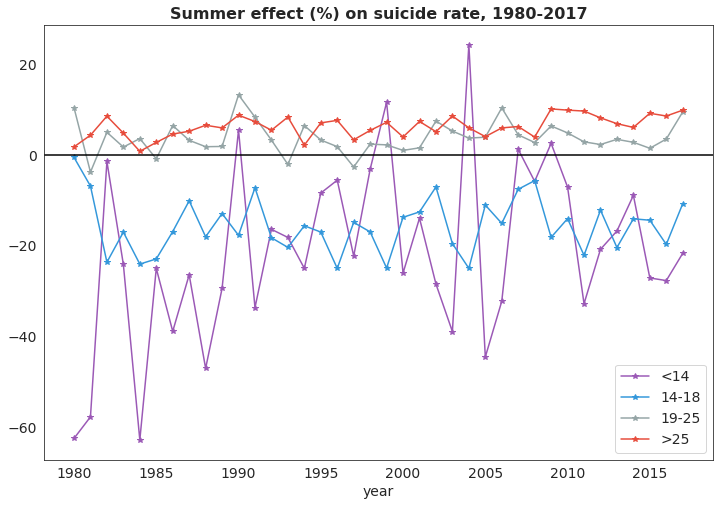

In [101]:
# old

param_percent_by_year = params_by_year/intercept_by_year *100
param_percent_by_year.plot(figsize=(12, 8), style='-*', color=COLORS)
_ = plt.title('Summer effect (%) on suicide rate' + year_range_str, fontsize=16, weight='heavy')
_ = plt.xticks(fontsize=14)
_ = plt.xlabel('year', fontsize=14)
_ = plt.yticks(fontsize=14)
_ = plt.axhline(0.0, color='k')
_ = plt.legend(fontsize=14)
if SAVE_FIGS:
    plt.savefig('figures/summer_coefficient_div_intercept.png', dpi=300, bbox_inches='tight')